In [2]:
import numpy as np
import pandas as pd


In [13]:
#Load dataset
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

original = pd.read_csv("sample_submission.csv")
original['y'] = original['y'].map({'no': 0, 'yes': 1})

# Add a 'dataset' column to track source
train['dataset'] = 'train'
test['dataset'] = 'test'

original['dataset'] = 'train'



# Combine train and test datasets for unified preprocessing
df = pd.concat([train, test], axis=0).reset_index(drop=True)

# 🧾 Display dataset shape
print("Dataset shape:", df.shape)

# 👁️ Preview the data
df

Dataset shape: (1000000, 19)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,dataset
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0.0,train
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0.0,train
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0.0,train
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0.0,train
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,43,management,married,tertiary,no,0,yes,no,cellular,18,nov,65,2,-1,0,unknown,NaN,test
999996,999996,40,services,married,unknown,no,522,yes,no,cellular,19,nov,531,1,189,1,failure,NaN,test
999997,999997,63,retired,married,primary,no,33,no,no,cellular,3,jul,178,1,92,8,success,NaN,test
999998,999998,50,blue-collar,married,primary,no,2629,yes,no,unknown,30,may,163,2,-1,0,unknown,NaN,test


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id         1000000 non-null  int64  
 1   age        1000000 non-null  int64  
 2   job        1000000 non-null  object 
 3   marital    1000000 non-null  object 
 4   education  1000000 non-null  object 
 5   default    1000000 non-null  object 
 6   balance    1000000 non-null  int64  
 7   housing    1000000 non-null  object 
 8   loan       1000000 non-null  object 
 9   contact    1000000 non-null  object 
 10  day        1000000 non-null  int64  
 11  month      1000000 non-null  object 
 12  duration   1000000 non-null  int64  
 13  campaign   1000000 non-null  int64  
 14  pdays      1000000 non-null  int64  
 15  previous   1000000 non-null  int64  
 16  poutcome   1000000 non-null  object 
 17  y          750000 non-null   float64
 18  dataset    1000000 non-null  object 
dtypes

In [15]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']
Categorical Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'dataset']


In [16]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0]
missing_df

,Missing Values,Percentage
y,250000,25.0


In [17]:
df[numerical_cols].describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,750000.000000
mean,499999.500000,40.927879,1202.407136,16.116924,256.007423,2.576143,22.379557,0.299841,0.120651
std,288675.278932,10.094523,2812.750998,8.252748,272.268420,2.716302,77.219149,1.348254,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,249999.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,499999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,749999.250000,48.000000,1390.000000,21.000000,359.000000,3.000000,-1.000000,0.000000,0.000000
max,999999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [18]:
for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].value_counts())


Unique values in 'job':
job
management       234177
blue-collar      227468
technician       184043
admin.           108501
services          85521
retired           46796
self-employed     25444
entrepreneur      23673
unemployed        23647
housemaid         21157
student           15634
unknown            3939
Name: count, dtype: int64

Unique values in 'marital':
marital
married     641171
single      259551
divorced     99278
Name: count, dtype: int64

Unique values in 'education':
education
secondary    535407
tertiary     303545
primary      132499
unknown       28549
Name: count, dtype: int64

Unique values in 'default':
default
no     982994
yes     17006
Name: count, dtype: int64

Unique values in 'housing':
housing
yes    547822
no     452178
Name: count, dtype: int64

Unique values in 'loan':
loan
no     859980
yes    140020
Name: count, dtype: int64

Unique values in 'contact':
contact
cellular     649117
unknown      308523
telephone     42360
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)

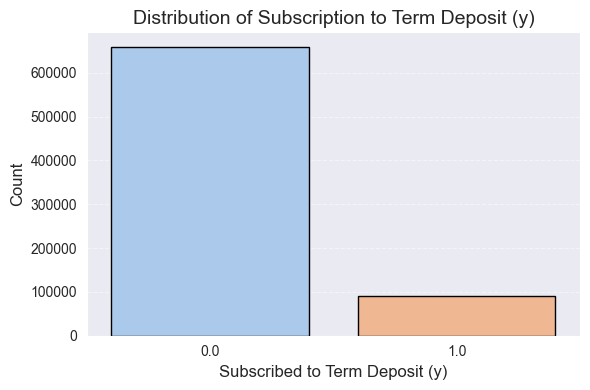


📊 Subscription to Term Deposit Value Counts (Proportions):
y
0.0    0.879
1.0    0.121
Name: proportion, dtype: float64


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='y', hue='y', palette='pastel', edgecolor='black', legend=False)
plt.title('Distribution of Subscription to Term Deposit (y)', fontsize=14)
plt.xlabel('Subscribed to Term Deposit (y)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Display normalized value counts (as proportions)
print("\n📊 Subscription to Term Deposit Value Counts (Proportions):")
print(df['y'].value_counts(normalize=True).round(3))

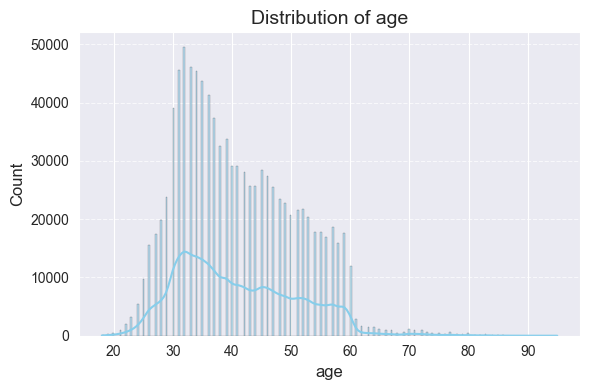


📊 Descriptive Stats for age:

count    1000000.000000
mean          40.927879
std           10.094523
min           18.000000
25%           33.000000
50%           39.000000
75%           48.000000
max           95.000000
Name: age, dtype: float64 
----------------------------------------


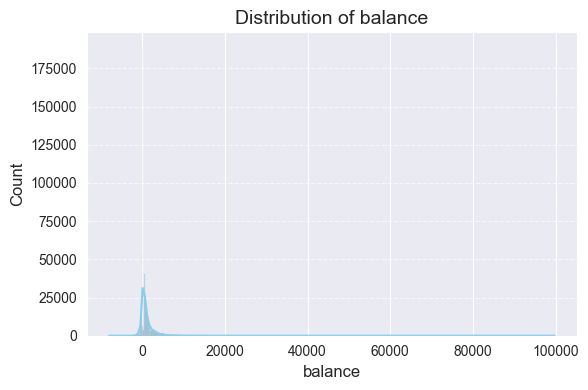


📊 Descriptive Stats for balance:

count    1000000.000000
mean        1202.407136
std         2812.750998
min        -8019.000000
25%            0.000000
50%          634.000000
75%         1390.000000
max        99717.000000
Name: balance, dtype: float64 
----------------------------------------


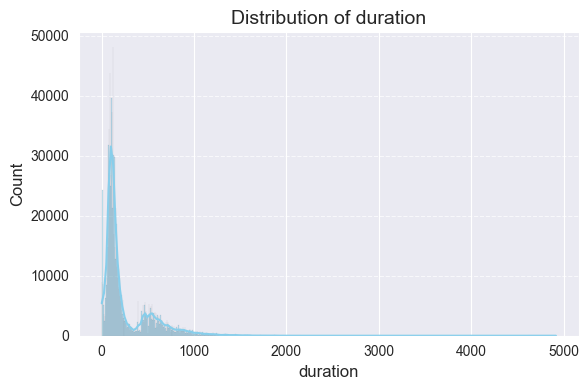


📊 Descriptive Stats for duration:

count    1000000.000000
mean         256.007423
std          272.268420
min            1.000000
25%           91.000000
50%          133.000000
75%          359.000000
max         4918.000000
Name: duration, dtype: float64 
----------------------------------------


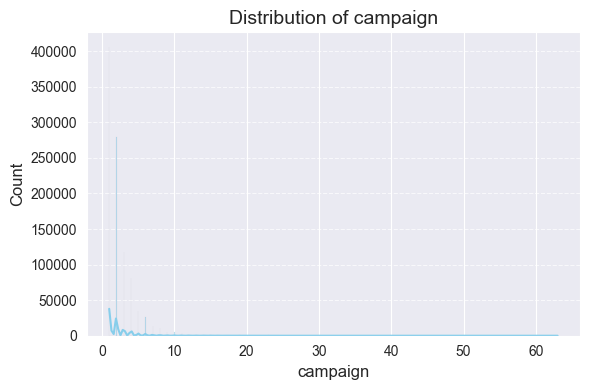


📊 Descriptive Stats for campaign:

count    1000000.000000
mean           2.576143
std            2.716302
min            1.000000
25%            1.000000
50%            2.000000
75%            3.000000
max           63.000000
Name: campaign, dtype: float64 
----------------------------------------


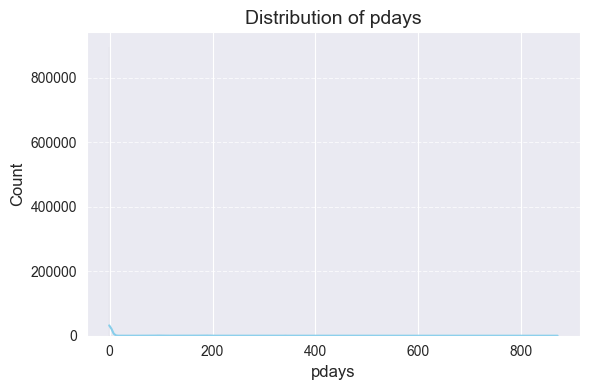


📊 Descriptive Stats for pdays:

count    1000000.000000
mean          22.379557
std           77.219149
min           -1.000000
25%           -1.000000
50%           -1.000000
75%           -1.000000
max          871.000000
Name: pdays, dtype: float64 
----------------------------------------


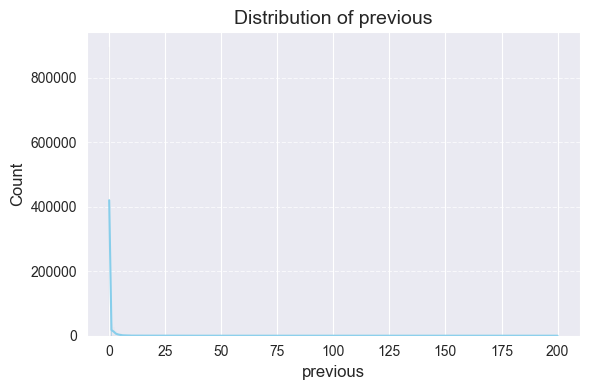


📊 Descriptive Stats for previous:

count    1000000.000000
mean           0.299841
std            1.348254
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max          200.000000
Name: previous, dtype: float64 
----------------------------------------


In [22]:
# List the numerical columns from your dataset
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print descriptive statistics
    print(f'\n📊 Descriptive Stats for {col}:\n')
    print(df[col].describe(), '\n' + '-'*40)

### Age

- Adults range from **18 up to 95**, with a **mean around 41**.
- The **middle 50%** lie between **33 and 48** — a fairly tight spread around the mean.


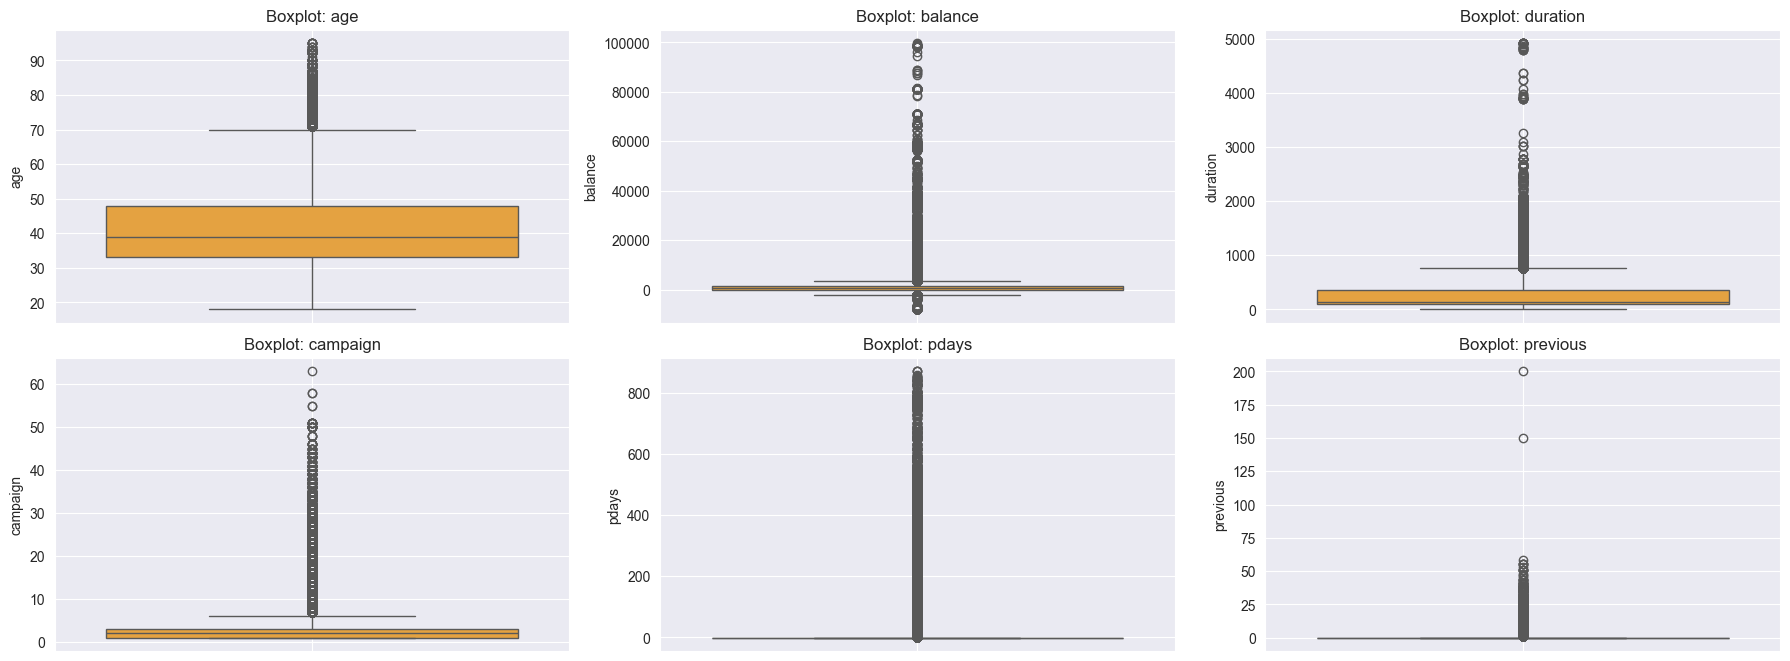

In [23]:
# 📦 Outlier Detection via Boxplots
plt.figure(figsize=(18, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=df, y=col, color='#FFA726')
    plt.title(f"Boxplot: {col}")
    plt.grid(True)
plt.tight_layout()
plt.show()

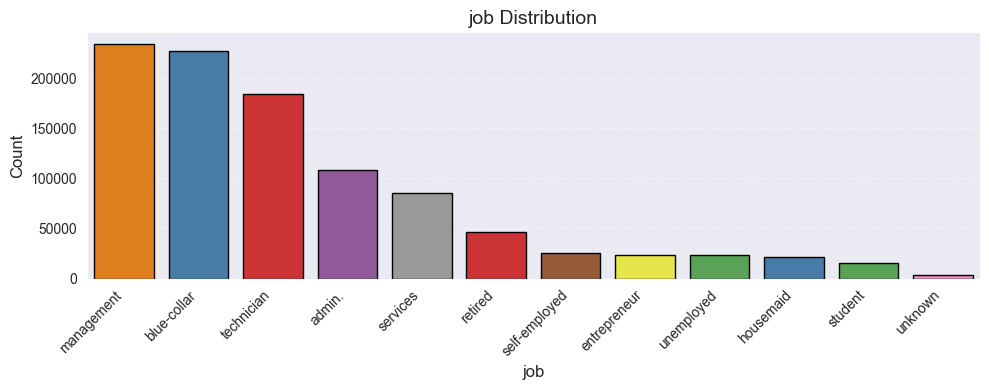


📊 Proportion of Each Category in "job":

job
management       0.234
blue-collar      0.227
technician       0.184
admin.           0.109
services         0.086
retired          0.047
self-employed    0.025
entrepreneur     0.024
unemployed       0.024
housemaid        0.021
student          0.016
unknown          0.004
Name: proportion, dtype: float64 
----------------------------------------


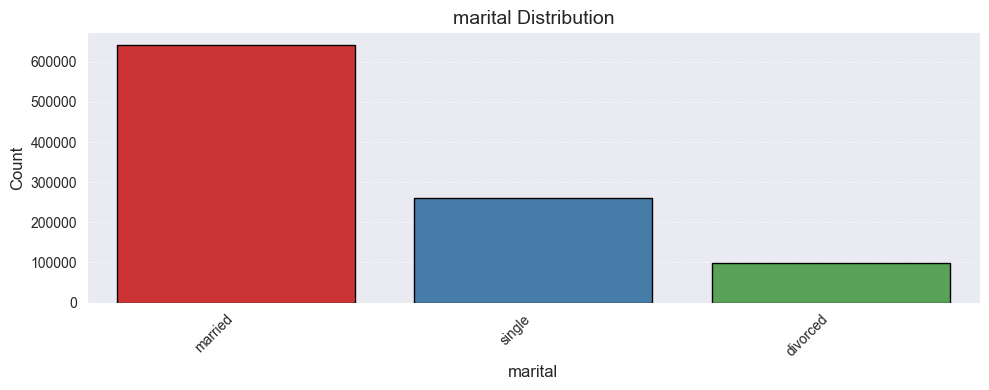


📊 Proportion of Each Category in "marital":

marital
married     0.641
single      0.260
divorced    0.099
Name: proportion, dtype: float64 
----------------------------------------


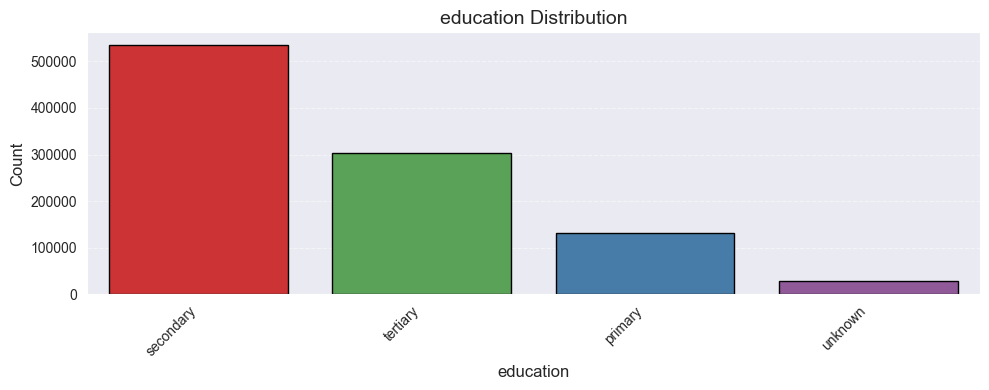


📊 Proportion of Each Category in "education":

education
secondary    0.535
tertiary     0.304
primary      0.132
unknown      0.029
Name: proportion, dtype: float64 
----------------------------------------


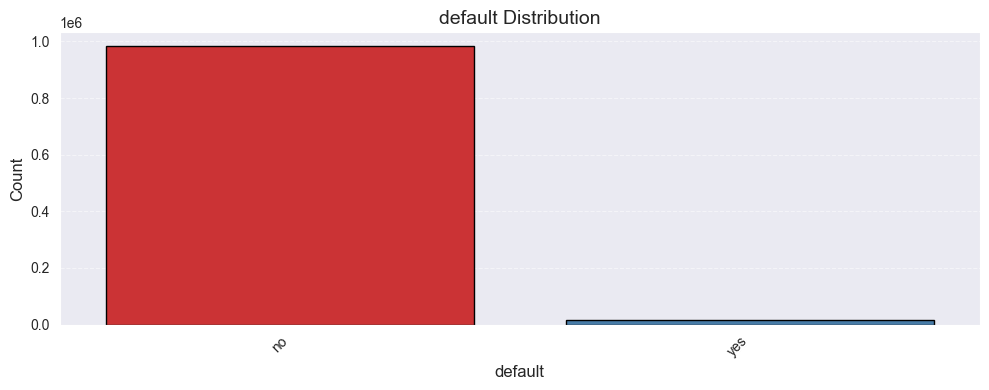


📊 Proportion of Each Category in "default":

default
no     0.983
yes    0.017
Name: proportion, dtype: float64 
----------------------------------------


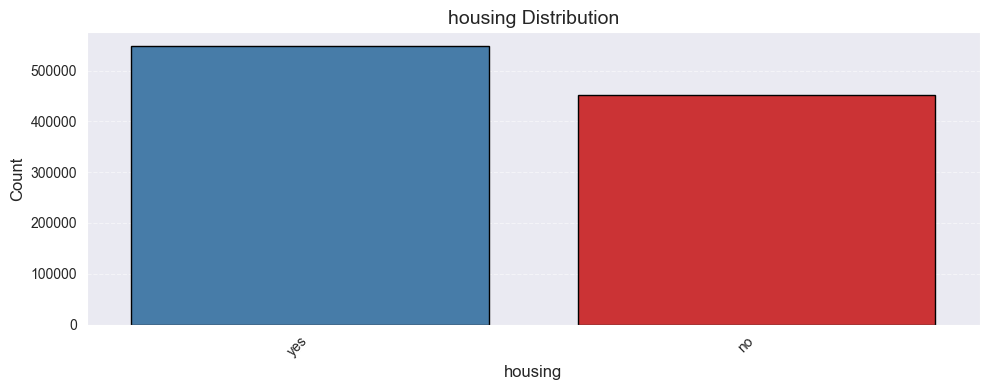


📊 Proportion of Each Category in "housing":

housing
yes    0.548
no     0.452
Name: proportion, dtype: float64 
----------------------------------------


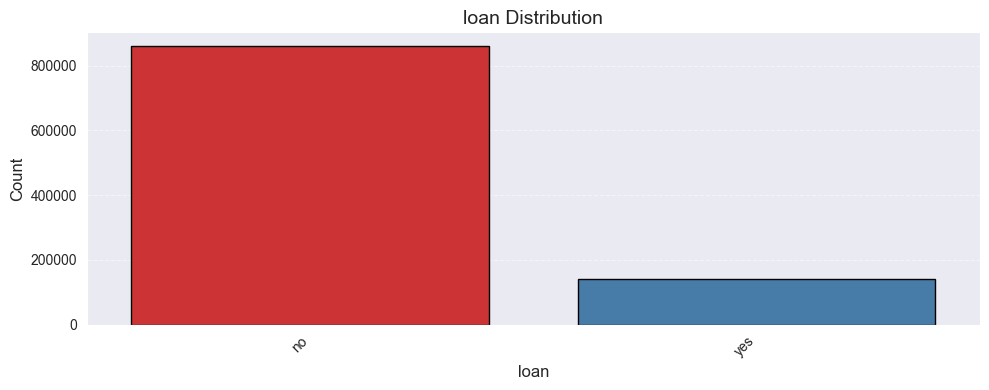


📊 Proportion of Each Category in "loan":

loan
no     0.86
yes    0.14
Name: proportion, dtype: float64 
----------------------------------------


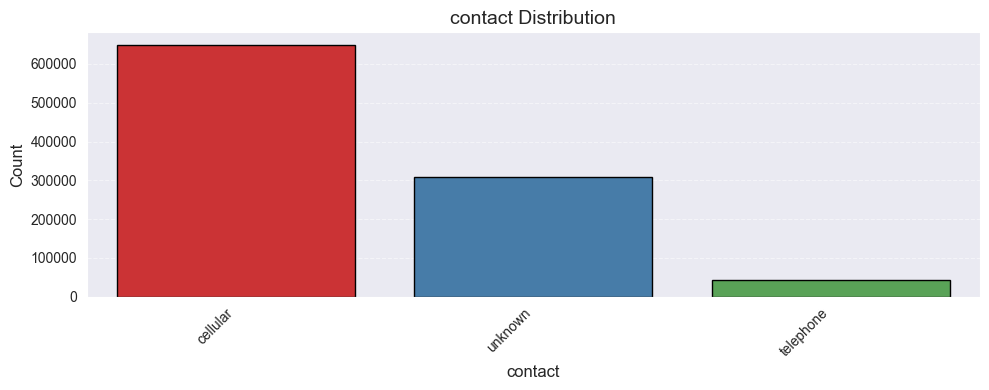


📊 Proportion of Each Category in "contact":

contact
cellular     0.649
unknown      0.309
telephone    0.042
Name: proportion, dtype: float64 
----------------------------------------


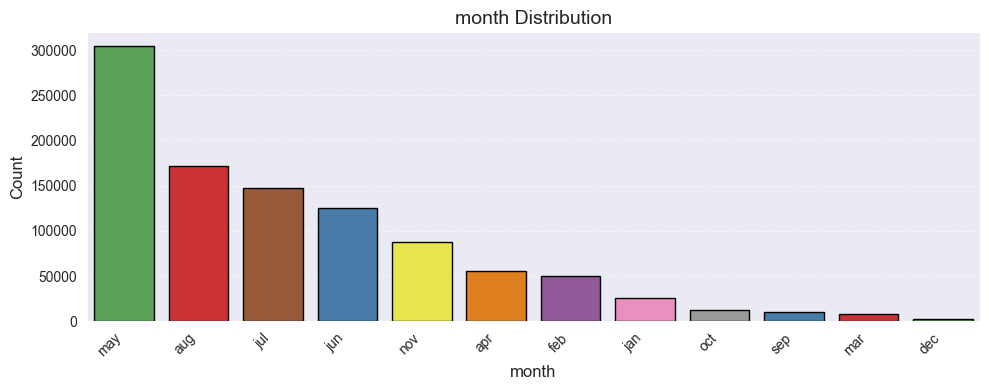


📊 Proportion of Each Category in "month":

month
may    0.304
aug    0.172
jul    0.147
jun    0.125
nov    0.088
apr    0.055
feb    0.050
jan    0.025
oct    0.012
sep    0.010
mar    0.008
dec    0.003
Name: proportion, dtype: float64 
----------------------------------------


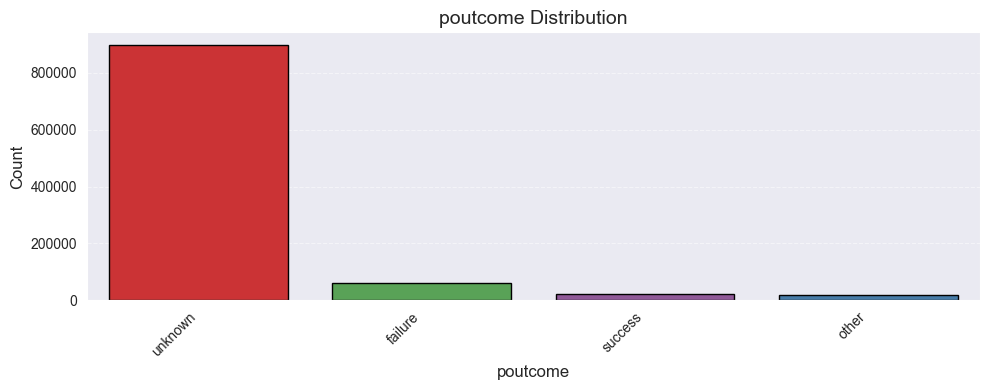


📊 Proportion of Each Category in "poutcome":

poutcome
unknown    0.897
failure    0.060
success    0.024
other      0.020
Name: proportion, dtype: float64 
----------------------------------------


In [27]:
# 📊 Distribution of Categorical Features (single bar per category; colorful; no warning)
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for col in cat_cols:
    order = df[col].value_counts().index

    plt.figure(figsize=(10, 4))
    sns.countplot(
        data=df,
        x=col,
        hue=col,                              # <-- ключевой трюк: hue совпадает с x
        order=order,
        palette='Set1',
        edgecolor='black',
        legend=False                          # скрываем легенду, чтобы не дублировалась
    )
    plt.title(f'{col} Distribution', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 🧮 Пропорции категорий
    print(f'\n📊 Proportion of Each Category in "{col}":\n')
    print(df[col].value_counts(normalize=True).round(3), '\n' + '-'*40)

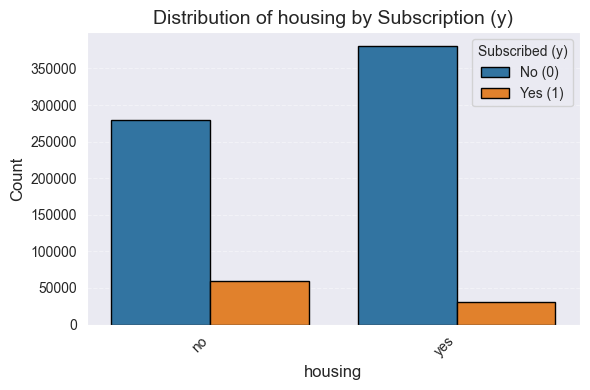

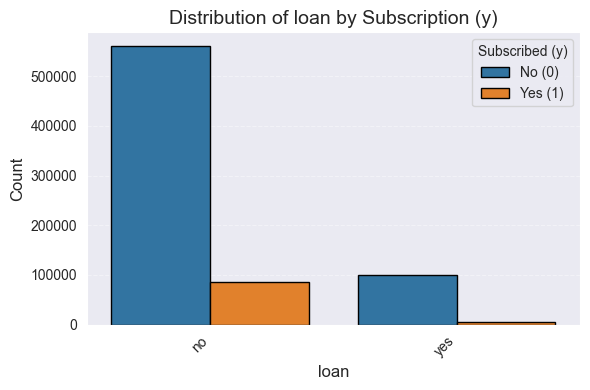

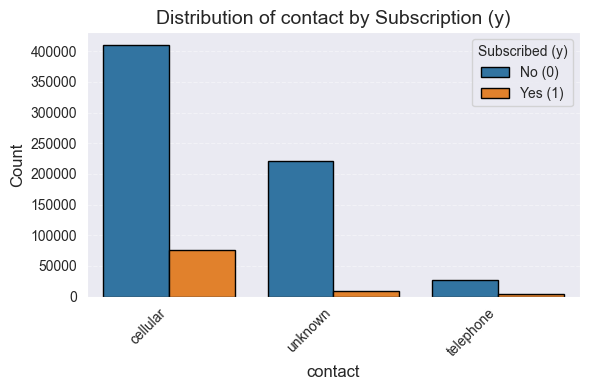

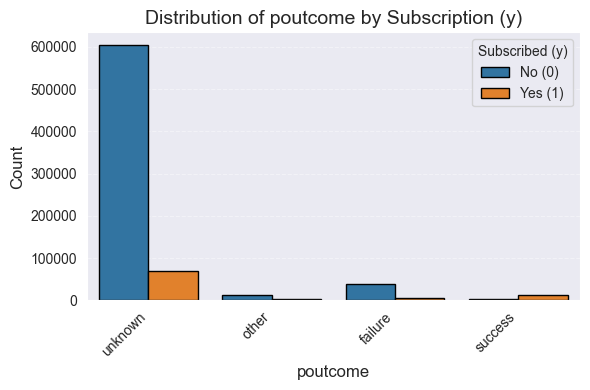

In [28]:
# 🎨 Categorical Feature Distributions by Subscription Status (y) - Custom Colors

cols_to_plot = ['housing', 'loan', 'contact', 'poutcome']
custom_palette = ['#1F77B4', '#FF7F0E']  # Blue for 0, Orange for 1

for col in cols_to_plot:
    plt.figure(figsize=(6, 4))
    sns.countplot(
        data=df,
        x=col,
        hue='y',
        palette=custom_palette,
        edgecolor='black'
    )
    plt.title(f'Distribution of {col} by Subscription (y)', fontsize=14)
    plt.xlabel(f'{col}', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Subscribed (y)', labels=['No (0)', 'Yes (1)'])
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

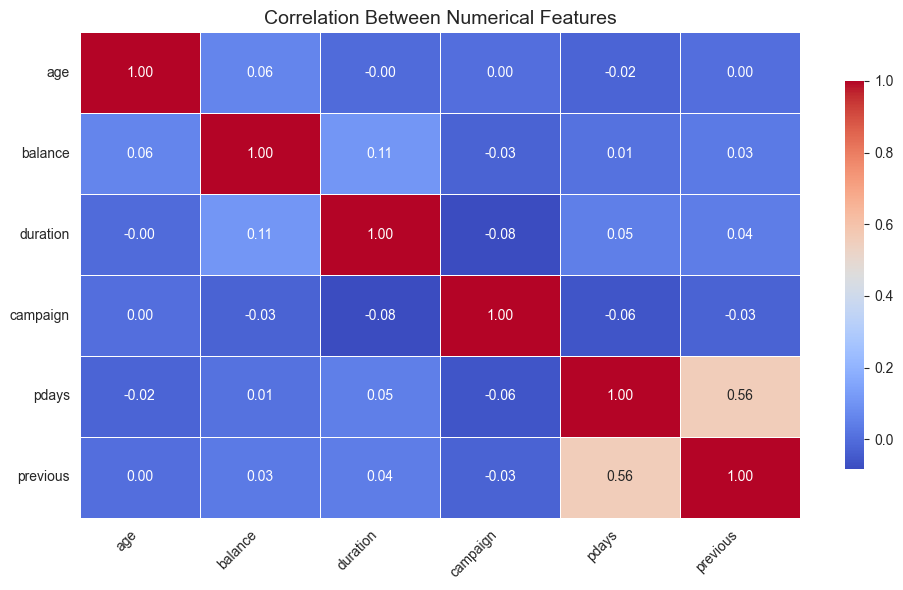

In [29]:
# 🔗 Correlation Between Numerical Features

plt.figure(figsize=(10, 6))
sns.heatmap(
    df[num_cols].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    linecolor='white',
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Between Numerical Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\golan\AppData\Local\Temp\ipykernel_5704\2339133315.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\golan\AppData\Local\Temp\ipykernel_5704\2339133315.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\golan\AppData\Local\Temp\ipykernel_5704\2339133315.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\golan\AppData\Local\Temp\ipykernel_5704\2339133315.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

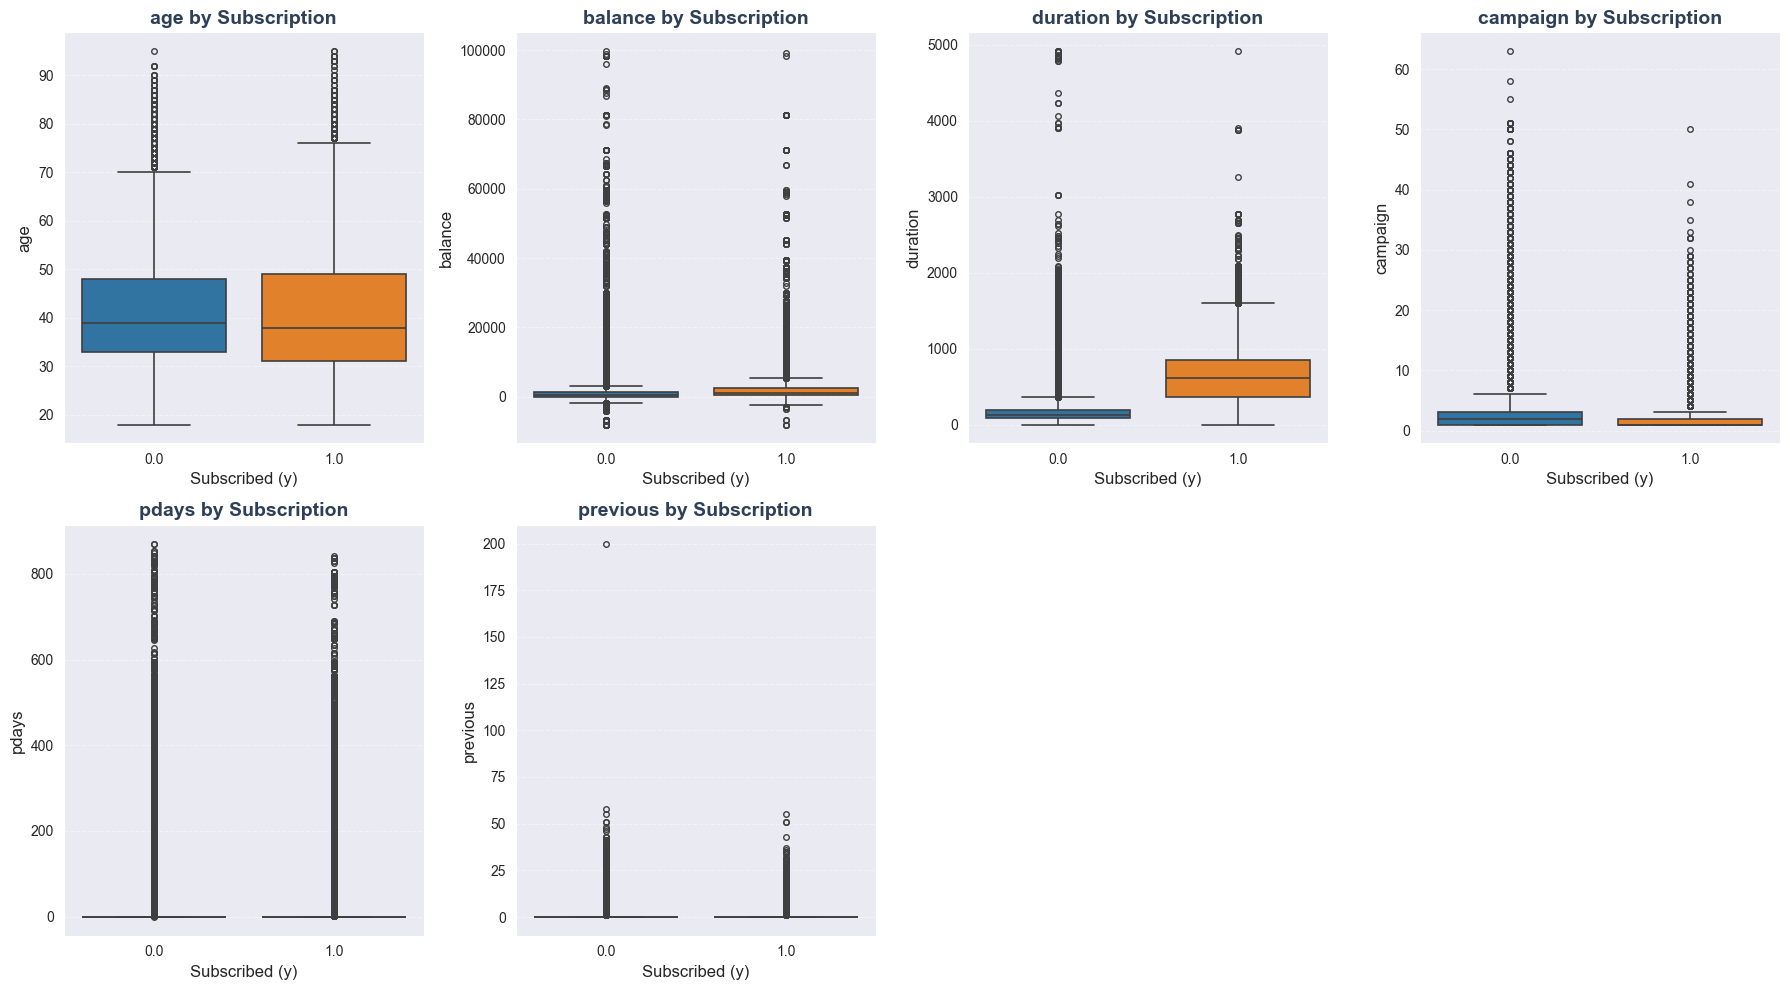

In [30]:
# 🧠 Feature vs Target Relationship (Numerical Features by Subscription)

plt.figure(figsize=(18, 10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(
        data=df,
        x='y',
        y=col,
        palette=['#1F77B4', '#FF7F0E'],  # Blue for 0, Orange for 1
        linewidth=1.2,
        fliersize=4
    )
    plt.title(f'{col} by Subscription', fontsize=14, fontweight='semibold', color='#2E4057')
    plt.xlabel('Subscribed (y)', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()